### On going questions
- Why large negative values for patients? (Even adjusting for on/off) -> taking 2yr 3yr progression seems to reduce negative values and lower variance overal

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Helper functions
def process_errors(frame, start, end) -> list:
    count = 0
    error_indices = []
    for index, row in frame.iterrows():
        checkSum = row.iloc[start:end].sum()
        givenTot = row.iloc[end]

        if checkSum != givenTot:
            print(f"Row {index} check failed: sum {checkSum} does not equal {givenTot}")
            error_indices.append(index)
            count += 1

    error_rows = frame.loc[error_indices]
    if count > 0:
        print("ROWS PRODUCED SUM MIS-MATCH")

    return error_rows

In [4]:
"""Originally included for debugging and checking the score status for NP3TOT"""
#stat_keys = list(df_pat_stat['COHORT_DEFINITION'].unique()) #for cohort enum definitions
#Un-necessary after first check
#df3_test = df3.drop(df3.iloc[:, 6:24], axis = 1) # Unnecessary, already removing columns below, so only used for checking error sums
#error_rows = process_errors(df3_test, 6,-6)
#if len(error_rows) > 0:
#        df3.drop(error_rows, inplace=True, axis=0)

'Originally included for debugging and checking the score status for NP3TOT'

In [10]:
UPDRS3 = "data/MDS-UPDRS_Part_III_10Jun2024.csv"
patient_status = "data/Participant_Status_03Jun2024.csv"

df3 = pd.read_csv(UPDRS3)
df_pat_stat = pd.read_csv(patient_status) #patient status data
df3 = df3.dropna(subset=['NP3TOT']).reset_index()
df3['INFODT'] = pd.to_datetime(df3['INFODT'], format="%m/%Y") #reformat INFODT (Assesment Date) to date-time objects

#df3[['OFFEXAM', 'ONEXAM']] = df3[['OFFEXAM', 'ONEXAM']].fillna(0)

df3['year'] = pd.DatetimeIndex(df3['INFODT']).year

#### Accounting for ON/OFF states
- ONOFFORDER :: First Part III exam OFF or ON (1 = OFF)
- OFFEXAM :: OFF exam performed
- ONEXAM :: ON exam performed

PDSTATE :: Which functional state is the participant currently in :: 
  - OFF :: Off is the typical functional state when participants have a poor response in spite of taking medications 
  - ON :: ON is the typical functional state when patients are receiving medication and have a good response
  
  - NUPDR3OF :: "OFF STATE"
  - NUPDR3ON :: "ON STATE"
  - NUPDRDOSE3 :: PDS UPDRS Part 3 treatment determination and part 3 motor exam
  - NUPDRS3 :: Part 3 (no treatment)

Keys: OFFEXAM, ONEXAM, maybe ONOFFORDER

In [11]:
"""TESTING BLOCK"""

desired_cols_df3 = {'NP3TOT', 'PATNO', 'EVENT_ID', 'ORIG_ENTRY', 'INFODT', 'PDSTATE', 'PAG_NAME','year'}
desired_cols_df_pat = {'PATNO', 'COHORT', 'ENROLL_STATUS', 'ENROLL_AGE'}

pat_filtered = df_pat_stat.drop(columns=set(df_pat_stat.columns) - desired_cols_df_pat)
df3_filtered = df3.drop(columns=set(df3.columns) - desired_cols_df3)

df3_full_filtered = pd.merge(df3_filtered, pat_filtered, on="PATNO")
df3_full_filtered = df3_full_filtered[df3_full_filtered['ENROLL_STATUS'].isin(['Enrolled', 'Withdrew', 'Complete'])]
full_sorted = df3_full_filtered.sort_values(['PATNO', 'INFODT']) #accounts for months as well

full_sorted

PATNO EVENT_ID    PAG_NAME     INFODT PDSTATE  NP3TOT ORIG_ENTRY  \
0        3000       BL     NUPDRS3 2011-02-01     NaN     4.0    02/2011   
1        3000      V04     NUPDRS3 2012-03-01     NaN     1.0    03/2012   
2        3000      V06     NUPDRS3 2013-02-01     NaN     4.0    02/2013   
3        3000      V08     NUPDRS3 2014-03-01     NaN     2.0    05/2014   
4        3000      V10     NUPDRS3 2015-03-01     NaN    19.0    03/2015   
...       ...      ...         ...        ...     ...     ...        ...   
22915  324862       BL  NUPDRDOSE3 2024-04-01     NaN    13.0    04/2024   
22917  325234       BL  NUPDRDOSE3 2024-04-01     NaN     3.0    04/2024   
22918  325566       BL  NUPDRDOSE3 2024-04-01     NaN    13.0    04/2024   
22919  329289       BL  NUPDRDOSE3 2024-04-01     NaN    27.0    04/2024   
22921  333703       BL  NUPDRDOSE3 2024-05-01     NaN     7.0    05/2024   

       year  COHORT ENROLL_STATUS  ENROLL_AGE  
0      2011       2      Enrolled        69.1  
1      2012       2      Enrolled        69.1  
2      2013       2      Enrolled        69.1  
3      2014       2      Enrolled        69.1  
4      2015       2      Enrolled        69.1  
...     ...     ...           ...         ...  
22915  2024       1      Enrolled        56.9  
22917  2024       4      Enrolled        59.4  
22918  2024       1      Enrolled        51.4  
22919  2024       1      Enrolled        62.1  
22921  2024       4      Enrolled        63.4  

[22615 rows x 11 columns]

### Original analytical dataset

In [271]:
desired_cols_df3 = {'NP3TOT', 'PATNO', 'EVENT_ID', 'ORIG_ENTRY', 'INFODT', 'PDSTATE', 'PAG_NAME','year'}
desired_cols_df_pat = {'PATNO', 'COHORT', 'ENROLL_STATUS', 'ENROLL_AGE'}
sub_scores = {'NP3SPCH','NP3FACXP', 'NP3RIGN', 'NP3RIGRU', 'NP3RIGLU', 'NP3RIGRL', 'NP3RIGLL', 'NP3FTAPR', 'NP3FTAPL', 'NP3HMOVR', 'NP3HMOVL', 'NP3PRSPR', 'NP3PRSPL', 'NP3TTAPR', 'NP3TTAPL', 'NP3LGAGR', 'NP3LGAGL', 'NP3RISNG', 'NP3GAIT', 'NP3FRZGT', 'NP3PSTBL', 'NP3POSTR', 'NP3BRADY', 'NP3PTRMR', 'NP3PTRML', 'NP3KTRMR', 'NP3KTRML', 'NP3RTARU', 'NP3RTALU', 'NP3RTARL', 'NP3RTALL', 'NP3RTALJ', 'NP3RTCON', 'NP3TOT'}
desired_cols_sub_scores = desired_cols_df3.union(sub_scores)

dropped_cols_df3 = set(df3.columns) - desired_cols_df3
dropped_cols_df_pat = set(df_pat_stat.columns) - desired_cols_df_pat
dropped_cols_sub_scores = set(df3.columns) - desired_cols_sub_scores

df3_filtered = df3.drop(columns=dropped_cols_df3)
df_pat_filtered = df_pat_stat.drop(columns=dropped_cols_df_pat)
df3_sub_filtered = df3.drop(columns=dropped_cols_sub_scores)
#merge the two on PATNO
df3_full_filtered = pd.merge(df3_filtered, df_pat_filtered, on="PATNO")
df3_full_sub = pd.merge(df3_sub_filtered, df_pat_filtered, on="PATNO")
#drop non-enrolled patients
df3_full_filtered = df3_full_filtered[df3_full_filtered['ENROLL_STATUS'] == 'Enrolled']
df3_full_sub = df3_full_sub[df3_full_sub['ENROLL_STATUS'] == 'Enrolled']

full_sorted = df3_full_filtered.sort_values(['PATNO', 'INFODT'])
full_sub_sorted = df3_full_sub.sort_values(['PATNO', 'INFODT'])

In [12]:
group = full_sorted.groupby('PATNO')
#OG code, doesn't make a difference
#full_sorted['delta_NP3TOT'] = group['NP3TOT'].diff()
#full_sorted['delta_years'] = group['INFODT'].diff().dt.days / 365
#full_sorted['delta_norm'] = full_sorted['delta_NP3TOT'] / full_sorted['delta_years']
# Let's see how these behave
full_sorted['delta_NP3TOT'] = group['NP3TOT'].diff()
full_sorted['delta_norm'] = group['NP3TOT'].diff() / (group['INFODT'].diff().dt.days / 365)
#full_sorted['delta_norm_2yrs'] = group['NP3TOT'].diff(2) / (group['INFODT'].diff(2).dt.days / 365)
#full_sorted['delta_norm_3yrs'] = group['NP3TOT'].diff(3) / (group['INFODT'].diff(3).dt.days / 365)
full_sorted_w_NaN = full_sorted
full_sorted.replace([np.inf, -np.inf], np.nan, inplace=True)
full_sorted[full_sorted['COHORT'] == 1].head(20)
#full_sorted = full_sorted.dropna(subset=['delta_norm']).reset_index(drop=True)

PATNO EVENT_ID    PAG_NAME     INFODT PDSTATE  NP3TOT ORIG_ENTRY  year  \
10   3001       SC     NUPDRS3 2011-02-01     NaN    18.0    02/2011  2011   
9    3001       BL     NUPDRS3 2011-03-01     NaN    12.0    03/2011  2011   
11   3001      V01     NUPDRS3 2011-05-01     NaN    18.0    06/2011  2011   
12   3001      V02     NUPDRS3 2011-08-01     NaN    23.0    08/2011  2011   
13   3001      V03     NUPDRS3 2011-11-01     NaN    19.0    12/2011  2011   
14   3001      V04     NUPDRS3 2012-03-01     NaN    20.0    04/2012  2012   
15   3001      V05     NUPDRS3 2012-09-01     NaN    29.0    09/2012  2012   
16   3001      V06     NUPDRS3 2013-05-01     NaN    39.0    05/2013  2013   
17   3001      V07     NUPDRS3 2013-09-01      ON    25.0    10/2013  2013   
18   3001      V08     NUPDRS3 2014-04-01      ON    34.0    07/2014  2014   
19   3001      V09     NUPDRS3 2014-11-01      ON    42.0    11/2014  2014   
20   3001      V10     NUPDRS3 2015-04-01     OFF    39.0    04/2015  2015   
21   3001      V10    NUPDRS3A 2015-04-01      ON    35.0    04/2015  2015   
22   3001      V11     NUPDRS3 2015-09-01      ON    28.0    09/2015  2015   
23   3001      V12     NUPDRS3 2016-06-01     OFF    34.0    07/2016  2016   
24   3001      V12    NUPDRS3A 2016-06-01      ON    26.0    07/2016  2016   
25   3001      V14     NUPDRS3 2018-03-01     OFF    36.0    04/2018  2018   
26   3001      V14    NUPDRS3A 2018-03-01      ON    25.0    04/2018  2018   
27   3001      V15     NUPDRS3 2019-03-01     OFF    37.0    03/2019  2019   
28   3001      V17  NUPDRDOSE3 2021-09-01     OFF    58.0    01/2022  2021   

    COHORT ENROLL_STATUS  ENROLL_AGE  delta_NP3TOT  delta_norm  
10       1      Enrolled        65.1           NaN         NaN  
9        1      Enrolled        65.1          -6.0  -78.214286  
11       1      Enrolled        65.1           6.0   35.901639  
12       1      Enrolled        65.1           5.0   19.836957  
13       1      Enrolled        65.1          -4.0  -15.869565  
14       1      Enrolled        65.1           1.0    3.016529  
15       1      Enrolled        65.1           9.0   17.853261  
16       1      Enrolled        65.1          10.0   15.082645  
17       1      Enrolled        65.1         -14.0  -41.544715  
18       1      Enrolled        65.1           9.0   15.495283  
19       1      Enrolled        65.1           8.0   13.644860  
20       1      Enrolled        65.1          -3.0   -7.251656  
21       1      Enrolled        65.1          -4.0         NaN  
22       1      Enrolled        65.1          -7.0  -16.699346  
23       1      Enrolled        65.1           6.0    7.992701  
24       1      Enrolled        65.1          -8.0         NaN  
25       1      Enrolled        65.1          10.0    5.721003  
26       1      Enrolled        65.1         -11.0         NaN  
27       1      Enrolled        65.1          12.0   12.000000  
28       1      Enrolled        65.1          21.0    8.377049

#### Define datasets for ON vs OFF comparison
- another idea :: add column which flags on vs off (and others) then we can just filter on that when we do the final distrubutions

CODES COHORT:

1 - PD

2 - TRUE CONTROL

3 - SWEDD

4 - PRODROMAL

In [13]:
PD_full_sorted = full_sorted[full_sorted['COHORT'] == 1]
PD_on = PD_full_sorted[(PD_full_sorted['PDSTATE'] == 'ON') | (PD_full_sorted['PAG_NAME'] == 'NUPDR3ON')]['delta_norm']
PD_off_or_nan = PD_full_sorted[(PD_full_sorted['PDSTATE'] != 'ON') & (PD_full_sorted['PAG_NAME'] != 'NUPDR3ON')]['delta_norm']
control = full_sorted[full_sorted['COHORT']==2]['delta_norm']

len(PD_off_or_nan)

8076

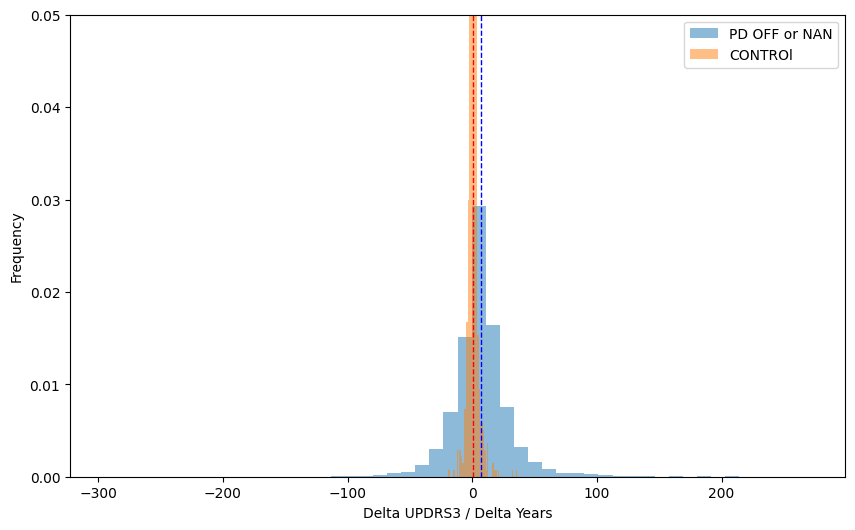

In [274]:
plt.figure(figsize=(10,6))

plt.hist(PD_off_or_nan, alpha=0.5, bins=50, density=True, label='PD OFF or NAN')
plt.hist(control, alpha=0.5, bins=50, density=True, label='CONTROl')

plt.axvline(PD_off_or_nan.mean(), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(control.mean(), color='red', linestyle='dashed', linewidth=1)

#plt.xlim((-2,25))
plt.ylim((0,0.05))

plt.xlabel('Delta UPDRS3 / Delta Years')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

# Show plot
plt.show()

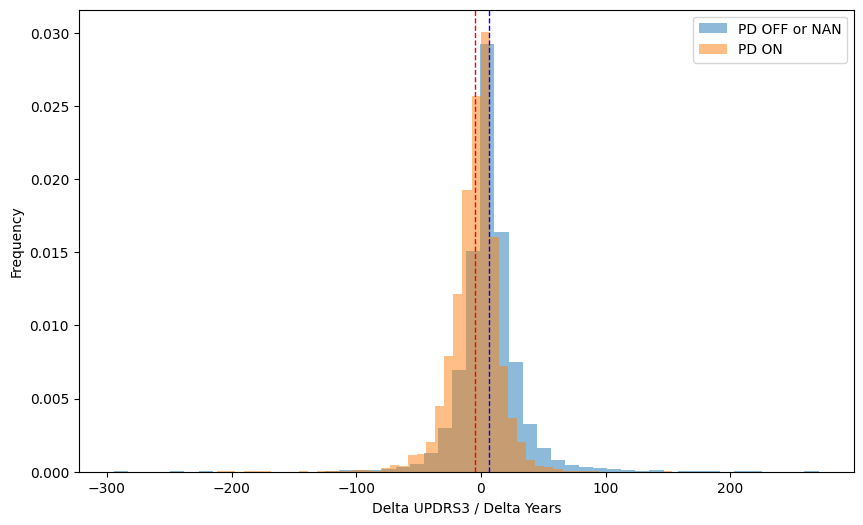

In [275]:
plt.figure(figsize=(10,6))

plt.hist(PD_off_or_nan, alpha=0.5, bins=50, density=True, label='PD OFF or NAN')
plt.hist(PD_on, alpha=0.5, bins=50, density=True, label='PD ON')

plt.axvline(PD_off_or_nan.mean(), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(PD_on.mean(), color='red', linestyle='dashed', linewidth=1)

#plt.xlim((-2,25))
#plt.ylim((0,0.05))

plt.xlabel('Delta UPDRS3 / Delta Years')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

# Show plot
plt.show()

### Next


In [14]:
import plotly.express as px
import plotly.graph_objects as go

In [15]:
fig = px.histogram(PD_on,x = 'delta_norm')
fig2 = px.histogram(PD_off_or_nan)

fig.update_layout(title_text = "PD ON")
fig2.update_layout(title_text = "PD OFF or Un-treated")

fig.show()
fig2.show()

In [278]:
ZERO_LINE = 0

mean_on = np.mean(PD_on)
mean_off = np.mean(PD_off_or_nan)

hist1 = go.Histogram(
    x= PD_on,
    name='ON State',
    opacity=0.80
)

hist2 = go.Histogram(
    x=PD_off_or_nan,
    name='OFF or NaN',
    opacity=0.80
)

fig = go.Figure()
fig.add_trace(hist1)
fig.add_trace(hist2)

fig.add_vline(x = mean_on, line_width = 1, line_dash = 'dash', line_color = 'blue')
fig.add_vline(x = mean_off, line_width = 1, line_dash = 'dash', line_color = 'red')
fig.add_vline(x = ZERO_LINE, line_width = 1, line_dash = 'solid', line_color = 'black')

fig.update_layout(
    barmode='overlay', # Use 'stack' if you want stacked histograms
    title='Combined Histograms',
    xaxis_title='Value',
    yaxis_title='Count'
)

fig.show()

In [279]:
mean_control = np.mean(control)
mean_off = np.mean(PD_off_or_nan)

hist1 = go.Histogram(
    x= control,
    #histnorm='probability',
    name='Healthy Control',
    opacity=0.80
)

hist2 = go.Histogram(
    x=PD_off_or_nan,
    #histnorm='probability',
    name='OFF or NaN',
    opacity=0.80
)

fig = go.Figure()
fig.add_trace(hist1)
fig.add_trace(hist2)

fig.add_vline(x = mean_control, line_width = 1, line_dash = 'dash', line_color = 'blue')
fig.add_vline(x = mean_off, line_width = 1, line_dash = 'dash', line_color = 'red')
fig.add_vline(x = ZERO_LINE, line_width = 1, line_dash = 'solid', line_color = 'black')

fig.update_layout(
    barmode='overlay', # Use 'stack' if you want stacked histograms
    title='Combined Histograms',
    xaxis_title='Value',
    yaxis_title='Count'
)

fig.show()

### Patient Level Data & Sub-scores
- First let's look at the left tail of the PD (on/off) distribution
  - Pick some left tail cut-off and examine patients with values that fall into that range
  - Group by OFF / NaN and then do one or all of the following: 
    - Run 2 year, 3 year, ... etc UPDRS/time ratios to see if affect washes out 
    - (?)
- (Sub-scores) :: do some form of normalization, or just use UPDRS/time score 

#### May not need these (Have NaNs for sanity checks)

In [280]:
#PD_full_sorted_w_NaN = full_sorted_w_NaN[full_sorted_w_NaN['COHORT'] == 1]
#PD_on_w_NaN = PD_full_sorted_w_NaN[(PD_full_sorted_w_NaN['PDSTATE'] == 'ON') | (PD_full_sorted_w_NaN['PAG_NAME'] == 'NUPDR3ON')]
#PD_off_w_NaN = PD_full_sorted_w_NaN[(PD_full_sorted_w_NaN['PDSTATE'] != 'ON') & (PD_full_sorted_w_NaN['PAG_NAME'] != 'NUPDR3ON')]
#PD_off_w_NaN.head(20)

In [281]:
PD_on_2yr = PD_full_sorted[(PD_full_sorted['PDSTATE'] == 'ON') | (PD_full_sorted['PAG_NAME'] == 'NUPDR3ON')]['delta_norm_2yrs']
PD_off_or_nan_2yr = PD_full_sorted[(PD_full_sorted['PDSTATE'] != 'ON') & (PD_full_sorted['PAG_NAME'] != 'NUPDR3ON')]['delta_norm_2yrs']
control_2yr = full_sorted[full_sorted['COHORT']==2]['delta_norm_2yrs']

#3yr cohorts
PD_on_3yr = PD_full_sorted[(PD_full_sorted['PDSTATE'] == 'ON') | (PD_full_sorted['PAG_NAME'] == 'NUPDR3ON')]['delta_norm_3yrs']
PD_off_or_nan_3yr = PD_full_sorted[(PD_full_sorted['PDSTATE'] != 'ON') & (PD_full_sorted['PAG_NAME'] != 'NUPDR3ON')]['delta_norm_3yrs']
control_3yr = full_sorted[full_sorted['COHORT']==2]['delta_norm_3yrs']

In [282]:
# 2yr ON vs OFF
mean_on_2yr = np.mean(PD_on_2yr)
mean_off_2yr = np.mean(PD_off_or_nan_2yr)

hist1 = go.Histogram(
    x= PD_on_2yr,
    name='ON State 2yr',
    opacity=0.80
)

hist2 = go.Histogram(
    x=PD_off_or_nan_2yr,
    name='OFF 2yr',
    opacity=0.80
)

fig = go.Figure()
fig.add_trace(hist1)
fig.add_trace(hist2)

fig.add_vline(x = mean_on_2yr, line_width = 1, line_dash = 'dash', line_color = 'blue')
fig.add_vline(x = mean_off_2yr, line_width = 1, line_dash = 'dash', line_color = 'red')
fig.add_vline(x = ZERO_LINE, line_width = 1, line_dash = 'solid', line_color = 'black')

fig.update_layout(
    barmode='overlay', # Use 'stack' if you want stacked histograms
    title='Combined Histograms :: ON 2yr vs Off 2yr Progression',
    xaxis_title='Value',
    yaxis_title='Count'
)

fig.show()

In [283]:
# 2yr OFF vs 1yr OFF
#mean_off
mean_off_2yr = np.mean(PD_off_or_nan_2yr)

hist1 = go.Histogram(
    x= PD_off_or_nan,
    name='OFF 1yr',
    opacity=0.80
)

hist2 = go.Histogram(
    x=PD_off_or_nan_2yr,
    name='OFF 2yr',
    opacity=0.80
)

fig = go.Figure()
fig.add_trace(hist1)
fig.add_trace(hist2)

fig.add_vline(x = mean_off, line_width = 1, line_dash = 'dash', line_color = 'blue')
fig.add_vline(x = mean_off_2yr, line_width = 1, line_dash = 'dash', line_color = 'red')
fig.add_vline(x = ZERO_LINE, line_width = 1, line_dash = 'solid', line_color = 'black')

fig.update_layout(
    barmode='overlay', # Use 'stack' if you want stacked histograms
    title='Combined Histograms :: OFF 2yr vs Off 1yr Progression',
    xaxis_title='Value',
    yaxis_title='Count'
)

fig.show()

In [284]:
# 2yr OFF vs 2yr Control
mean_control_2yr = np.mean(control_2yr)
mean_off_2yr = np.mean(PD_off_or_nan_2yr)

hist1 = go.Histogram(
    x= control_2yr,
    name='Control 2yr',
    opacity=0.80
)

hist2 = go.Histogram(
    x=PD_off_or_nan_2yr,
    name='OFF 2yr',
    opacity=0.80
)

fig = go.Figure()
fig.add_trace(hist1)
fig.add_trace(hist2)

fig.add_vline(x = mean_control_2yr, line_width = 1, line_dash = 'dash', line_color = 'blue')
fig.add_vline(x = mean_off_2yr, line_width = 1, line_dash = 'dash', line_color = 'red')
fig.add_vline(x = ZERO_LINE, line_width = 1, line_dash = 'solid', line_color = 'black')

fig.update_layout(
    barmode='overlay', # Use 'stack' if you want stacked histograms
    title='Combined Histograms :: OFF 2yr vs Control 2yr',
    xaxis_title='Value',
    yaxis_title='Count'
)

fig.show()

In [285]:
# OFF Progression 1yr, 2yr, 3yr
# 2yr OFF vs 1yr OFF
#mean_off
#mean_off_2yr = np.mean(PD_off_or_nan_2yr)
mean_off_3yr = np.mean(PD_off_or_nan_3yr)

hist1 = go.Histogram(
    x= PD_off_or_nan,
    name='OFF 1yr',
    opacity=0.80
)

"""hist2 = go.Histogram(
    x=PD_off_or_nan_2yr,
    name='OFF 2yr',
    opacity=0.80
)"""

hist3 = go.Histogram(
    x=PD_off_or_nan_3yr,
    name='OFF 3yr',
    opacity=0.80
)

fig = go.Figure()
fig.add_trace(hist1)
#fig.add_trace(hist2)
fig.add_trace(hist3)

fig.add_vline(x = mean_off, line_width = 1, line_dash = 'dash', line_color = 'blue')
#fig.add_vline(x = mean_off_2yr, line_width = 1, line_dash = 'dash', line_color = 'red')
fig.add_vline(x = mean_off_3yr, line_width = 1, line_dash = 'solid', line_color = 'green')
fig.add_vline(x = ZERO_LINE, line_width = 1, line_dash = 'solid', line_color = 'black')

fig.update_layout(
    barmode='overlay', # Use 'stack' if you want stacked histograms
    title='Combined Histograms :: OFF 3yr vs OFF 2yr vs OFF 1yr ',
    xaxis_title='Value',
    yaxis_title='Count'
)

fig.show()

### Sub-score distributions

In [286]:
full_sub_sorted.head()

PATNO EVENT_ID PAG_NAME     INFODT PDSTATE  NP3SPCH  NP3FACXP  NP3RIGN  \
0   3000       BL  NUPDRS3 2011-02-01     NaN      0.0       0.0      0.0   
1   3000      V04  NUPDRS3 2012-03-01     NaN      0.0       0.0      0.0   
2   3000      V06  NUPDRS3 2013-02-01     NaN      0.0       0.0      0.0   
3   3000      V08  NUPDRS3 2014-03-01     NaN      0.0       0.0      0.0   
4   3000      V10  NUPDRS3 2015-03-01     NaN      0.0       0.0      0.0   

   NP3RIGRU  NP3RIGLU  ...  NP3RTARL  NP3RTALL  NP3RTALJ  NP3RTCON  NP3TOT  \
0       0.0       0.0  ...       0.0       0.0       0.0       0.0     4.0   
1       0.0       0.0  ...       0.0       0.0       0.0       0.0     1.0   
2       0.0       0.0  ...       0.0       0.0       0.0       0.0     4.0   
3       0.0       0.0  ...       0.0       0.0       0.0       0.0     2.0   
4       0.0       0.0  ...       0.0       0.0       0.0       0.0    19.0   

   ORIG_ENTRY  year  COHORT  ENROLL_STATUS  ENROLL_AGE  
0     02/2011  2011       2       Enrolled        69.1  
1     03/2012  2012       2       Enrolled        69.1  
2     02/2013  2013       2       Enrolled        69.1  
3     05/2014  2014       2       Enrolled        69.1  
4     03/2015  2015       2       Enrolled        69.1  

[5 rows x 44 columns]

In [294]:
#sub_scores
sub_delta_norms = []
grouped = full_sub_sorted.groupby('PATNO')
counter = 0
for col_id in list(sub_scores):
    sub_delta_norms.append( 
        pd.DataFrame(grouped[col_id].diff() / (grouped['INFODT'].diff().dt.days / 365))
    )
    counter+=1


for elem in sub_delta_norms:
    elem.rename(columns = {0 : "DNorm"}, inplace = True)
    elem.replace([np.inf, -np.inf], np.nan, inplace=True)
    elem.dropna(inplace=True)

type(sub_delta_norms[0])

pandas.core.frame.DataFrame

In [301]:
test_name = list(sub_delta_norms[0].columns)[0]
test = sub_delta_norms[0]['DNorm']

# 2yr ON vs OFF
test_mean = np.mean(test)

hist1 = go.Histogram(
    x = test,
    name=test_name,
    opacity=0.85
)

fig = go.Figure()
fig.add_trace(hist1)

fig.add_vline(x = test_mean, line_width = 1, line_dash = 'dash', line_color = 'blue')

fig.update_layout(
    barmode='overlay', # Use 'stack' if you want stacked histograms
    title='Histogram: ' + test_name,
    xaxis_title='Value',
    yaxis_title='Count'
)

fig.show()

In [298]:
from plotly.subplots import make_subplots
#import plotly.graph_objects as go

fig = make_subplots(rows=7, cols=5)
#fig.print_grid()
fig.update_layout(
    width=1200,
    height=1200,
)
fig.update_yaxes(automargin = True)
fig.update_xaxes(automargin = True)

counter = 0
for i in range(7):
    for j in range(5):
        #print(i,j,counter)

        if(counter >= len(sub_delta_norms)): break

        fig.append_trace(go.Histogram(
            x=sub_delta_norms[counter]['DNorm'],
            #name=sub_delta_norms[counter],
            #opacity=0.80
            ), row=i+1, col=j+1)
        counter+=1


fig.show()